# Simple Harmonic oscillator

## Import libraries

In [1]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

## The physics

Lagrangian for simple harmonic oscillator

$$
L =   \frac{1}{2} m(\frac{dx}{dt})^2 - \frac{1}{2} kx^2 
$$

Equation of motion (Euler Lagrange Equation) is given below

$$
m \dfrac{d^2x}{dt^2} = -kx~.
$$

## Solving analytically

The exact solution is given by 

$$
x(t) = A \cos{\omega t + \phi}
$$

where $$ \omega = \sqrt{\frac{k}{m}} $$. Lets make a quick plot for this with some dummy numbers to see what we are working with.

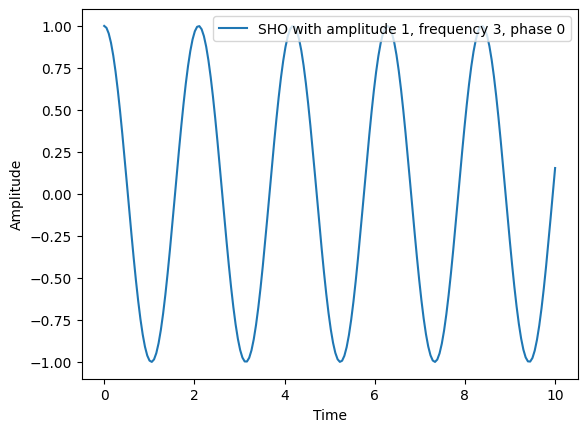

In [2]:
# Example parameters
example_amplitude = 1
example_phase = 0
example_frequency = 3

example_times = np.linspace(0,10,200) # Example input
def sho(amplitude, frequency, phase, time):
    return amplitude * np.cos(frequency * time + phase)
shos = sho(example_amplitude, example_frequency, example_phase, example_times)
plt.plot(example_times, shos)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend([f"SHO with amplitude {example_amplitude}, frequency {example_frequency}, phase {example_phase}"], loc="upper right")
plt.show()


## Solving with a NN

Lets try to fit a standard Neural network to some training data we get from our solution.

### Step 1: Create some training data from the known analytic solution

In [3]:
# Select some physics parameters
amplitude = 1
frequency = 30
phase = 0

# Create synethtic data
time = torch.linspace(0, 1, 200).view(-1,1)
sho_analytic_solution = sho(amplitude, frequency, phase, time).view(-1,1)

# Create a subsample of the data for training
time_samples = time[0:50:5]
sho_samples = sho_analytic_solution[0:50:5]


### Step 2: Create a standard Feed Forward Fully Connected Nueral network

Now that we have seen the solution, let's try to design a simple neural network to fit the data. We will use a simple feed forward neural network with 2 hidden layers. The input to the network will be time and the output will be the position of the oscillator at that time. Therefore, the input layer will have 1 neuron and the output layer will have 1 neuron. The number of neurons in the hidden layer is a hyperparameter that we can tune. We will use the Tanh activation function for the hidden layers and the linear activation function for the output layer. We will use the mean squared error loss function and the Adam optimizer for training the network.

In [4]:
class shoNN(torch.nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        """
        TODO: Define the input layer, hidden layers, and output layer.
        The input layer should be a linear layer followed by an activation function.
        The hidden layers should be a sequence of linear layers followed by activation functions.
        The output layer should be a linear layer.
        """
        # TODO: Implement the layers here
        self.input_layer = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        """
        TODO: Implement the forward pass.
        The input should pass through the input layer, the hidden layers, and the output layer in order.
        """
        # TODO: Implement the forward pass here
        
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [5]:
# Test the shoNN class
test_model = shoNN(1, 1, 20, 2)

# Set the weights of the model for testing
with torch.no_grad():
    for param in test_model.parameters():
        param.fill_(0.5)

assert isinstance(test_model, torch.nn.Module), "The shoNN class should inherit from torch.nn.Module."
assert hasattr(test_model, 'forward'), "The shoNN class should have a 'forward' method."

# Test a forward pass
input_data = torch.tensor([[0.0], [0.1], [0.2], [0.3]])
output_data = test_model(input_data)

assert output_data.shape == (4, 1), "The output shape is incorrect."

# Expected output
expected_output = torch.tensor([[10.499288],
                                [10.499669],
                                [10.499841],
                                [10.499922]])

assert torch.allclose(output_data, expected_output, atol=1e-6), "The output values are not as expected."

Before training the NN, lets visualise what we are about to do. The graph below shows the analytic solution in blue, which is an exact solution to the differential equation for a SHO. We have then sampled a subset of the solutions to the equation at specific times to create a training 'y' variable, and will be fed to the NN for training. 

Note that the training data onll covers a small subset of the full range of 'x' values. This is important as it highlights that we are not going to simply fit the NN to the functional data, rather a subset of the data and 'learn' the rest of the solution by providing it 'physical insight' directly into the loss function.

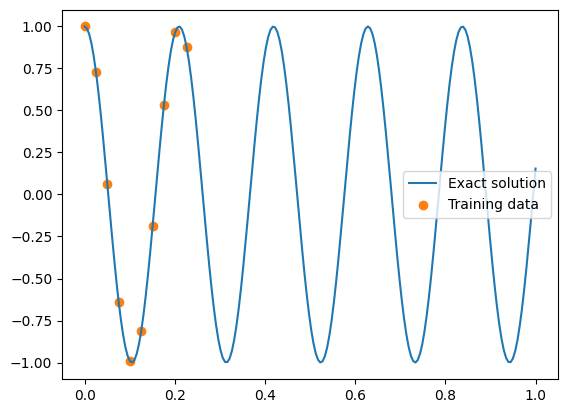

In [6]:
plt.figure()
plt.plot(time, sho_analytic_solution, label="Exact solution")
plt.scatter(time_samples, sho_samples, color="tab:orange", label="Training data")
plt.legend()
plt.show()


### Step 3: Create some plotting functions for easy visualisation

In [7]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


def save_gif_PIL(outfile, files, fps=5, loop=0):
    images = [Image.open(fn) for fn in files]
    images[0].save(outfile, save_all=True, append_images=images[1:], optimize=False, duration=1000/fps, loop=loop)

### Step 4: Train the NN on training data with a normal MSE loss

First we will train the NN with a normal MSE loss function and see how it performs. We will then plot the results to see how well the NN has learned the solution.

In [8]:
def simple_mse_loss(predicted: torch.tensor, target: torch.tensor) -> torch.tensor:
    """
    This loss function should return the mean squared error between the predicted and target values.
    Note that at this point, we are not including the physics loss.
    """
    predicted = predicted.squeeze()
    target = target.squeeze()

    loss = torch.mean((predicted - target) ** 2)
    return loss

assert simple_mse_loss(torch.tensor([[1.0], [2.0], [3.0]]), torch.tensor([[1.0], [2.0], [3.0]])).item() == 0.0, "The loss is not correct."
assert torch.allclose(simple_mse_loss(torch.tensor([[1.0], [2.0], [3.0]]), torch.tensor([[1.1], [2.1], [3.1]])).detach(), torch.tensor(0.01)), "The loss is not correct."

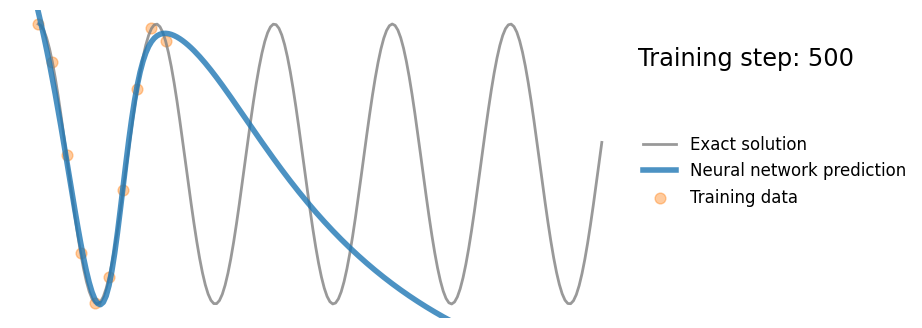

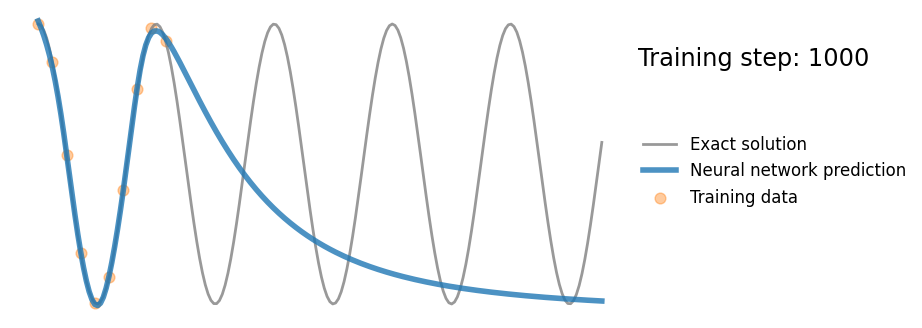

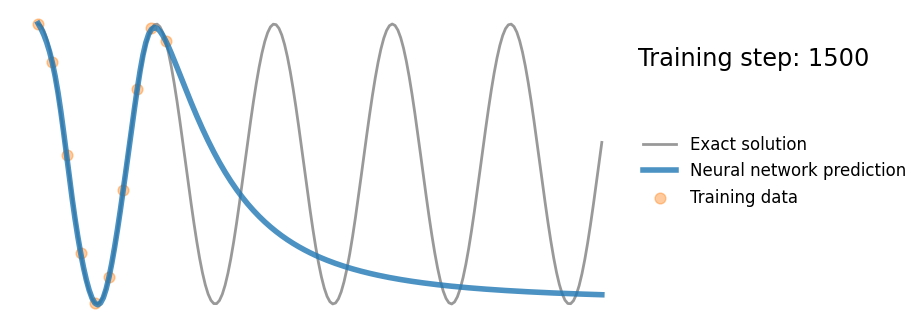

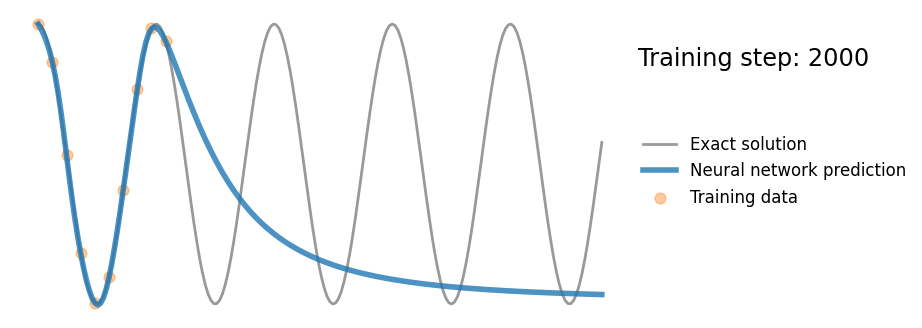

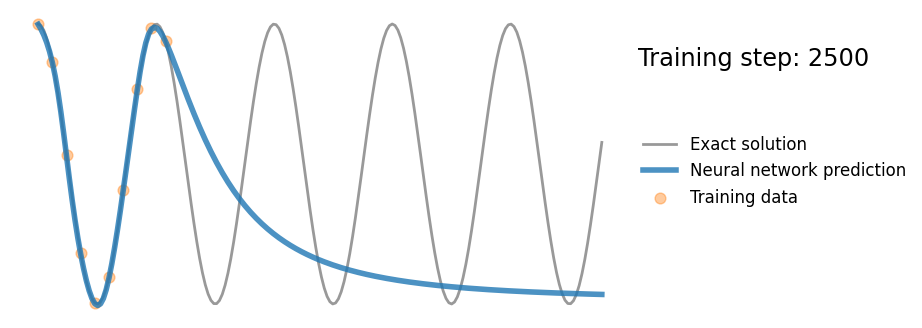

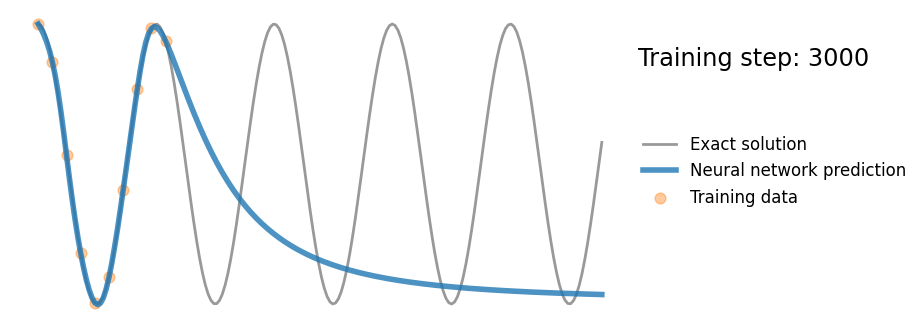

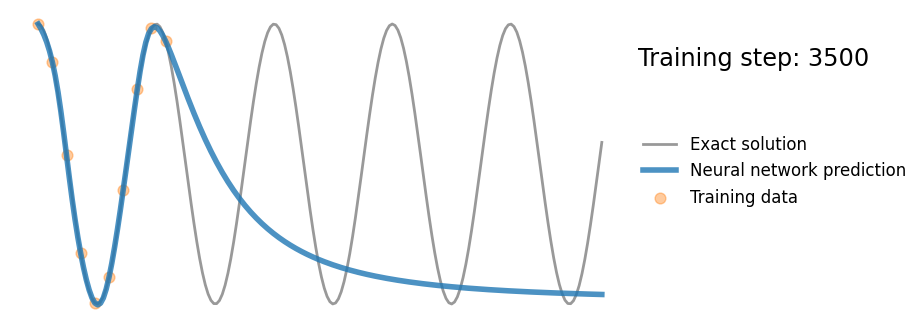

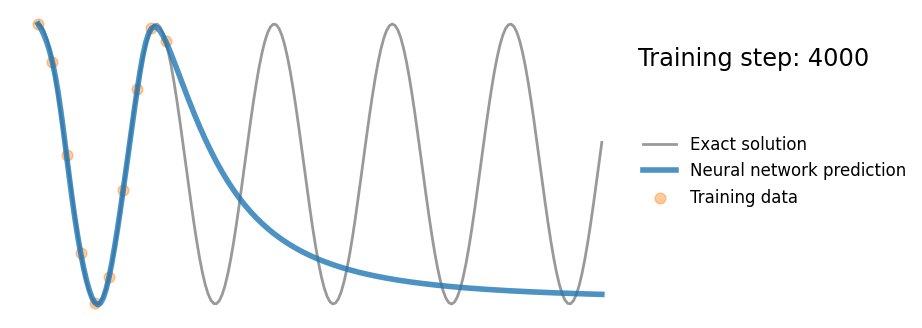

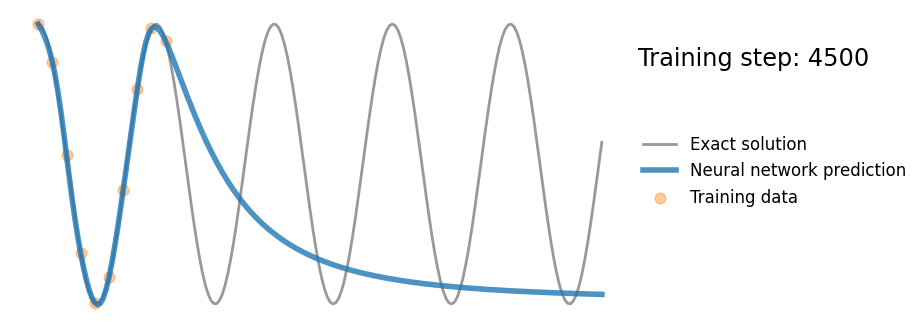

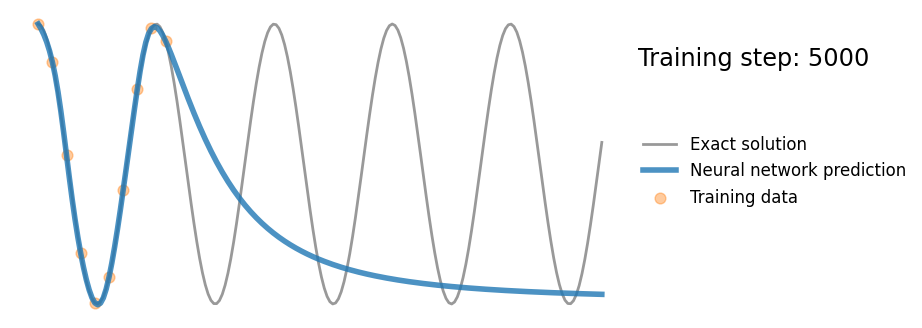

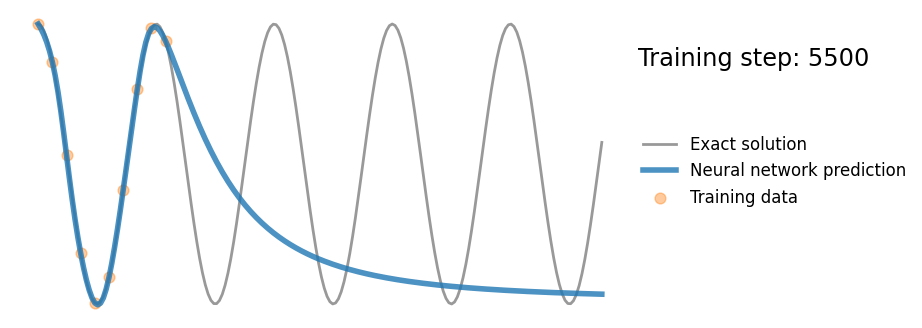

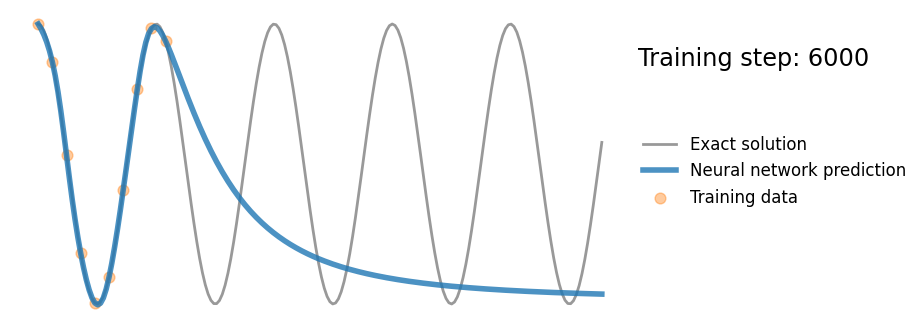

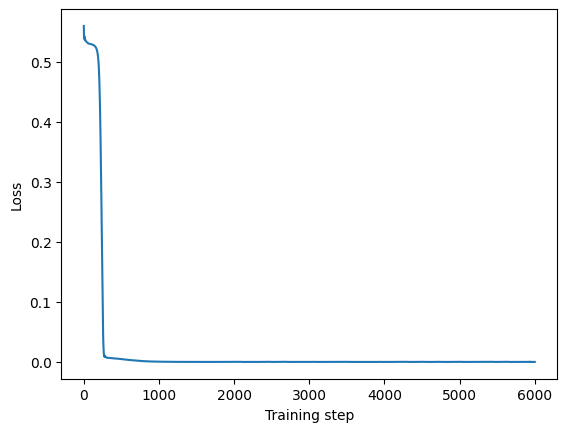

In [9]:
# train standard neural network to fit training data
torch.manual_seed(123)

# Instantiate the model that has one input (time) and one output (the amplitude of the SHO)
model = shoNN(1,1,32,3)
assert isinstance(model, torch.nn.Module), "model should be an instance of torch.nn.Module"
assert model.input_layer[0].in_features == 1, "The input dimension of the model should be 1."
assert model.output_layer.out_features == 1, "The output dimension of the model should be 1."

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
for i in range(6000):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss = simple_mse_loss(predicted=sho_predicted, target=sho_samples)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        
        sho_predicted_plot = model(time).detach()
        
        plot_result(time,sho_analytic_solution,time_samples,sho_samples,sho_predicted_plot)
        
        file = "../plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()
save_gif_PIL("nn_nosholoss.gif", files, fps=20, loop=0)

Lets reflect on these results.
1. We see that the NN fits the training data we provided perfectly, which is no surprise as it has more than enough parameters (in fact, in this case more parameters than data points). So the system is completely overfit
2. We see that it tries to learn but the loss function platues fairly rapidly with no change with training steps. The final result is a model that simply cannot predict the unseen data

### Step 5: Train the NN with SHO and boundary term loss

The SHO loss function is:

$$
L_{sho} = \frac{1}{N} \sum \left(\frac{d^2x}{dt^2} +\omega^2 x \right)^2
$$

And the boundary loss is:

$$
L_{boundary} = (x(t_{initial}) - 1)^2 + \left( \frac{dx}{dt}(t_{initial}) \right)^2
$$

where $t_{initial} = 0$. This simply says that the initial amplitude is 1 (and hence a cosine) and the initial velocity is 0.

Now lets train a NN with these loss terms and various example parameters

In [10]:
def compute_model_and_derivatives(model, time_vector):
    """
    This function should return the model outputs and the first and second derivatives of the model outputs with respect to time_vector.

    Use the torch.autograd.grad function to compute the derivatives of the model output with respect to time_vector.
    Args:
        model: The neural network model.
        time_vector: The input to the model.
    """
    time_vector.requires_grad = True

    model_outputs = model(time_vector)
    first_derivative = torch.autograd.grad(model_outputs, time_vector, torch.ones_like(model_outputs), create_graph=True)[0]
    second_derivative = torch.autograd.grad(first_derivative, time_vector, torch.ones_like(first_derivative), create_graph=True)[0]

    return model_outputs, first_derivative, second_derivative

In [11]:
# Test the compute_model_and_derivatives function
torch.manual_seed(123)
model = shoNN(1,1,32,3)
time_vector = torch.linspace(0, 1, steps=10).view(-1, 1).requires_grad_(True)
model_outputs, first_derivative, second_derivative = compute_model_and_derivatives(model, time_vector)

# Check the shapes of the outputs
assert model_outputs.shape == time_vector.shape, "The shape of model_outputs is not correct."
assert first_derivative.shape == time_vector.shape, "The shape of first_derivative is not correct."
assert second_derivative.shape == time_vector.shape, "The shape of second_derivative is not correct."

# Check the types of the outputs
assert isinstance(model_outputs, torch.Tensor), "model_outputs should be a torch.Tensor."
assert isinstance(first_derivative, torch.Tensor), "first_derivative should be a torch.Tensor."
assert isinstance(second_derivative, torch.Tensor), "second_derivative should be a torch.Tensor."

# Check the values of the outputs
assert torch.allclose(model_outputs, model(time_vector)), "model_outputs should be the output of the model."
assert torch.allclose(first_derivative, torch.autograd.grad(model_outputs, time_vector, torch.ones_like(model_outputs), create_graph=True)[0]), "first_derivative should be the first derivative of the model outputs."
assert torch.allclose(second_derivative, torch.autograd.grad(first_derivative, time_vector, torch.ones_like(first_derivative), create_graph=True)[0]), "second_derivative should be the second derivative of the model outputs."

Now that we can compute the derivatives, we define the loss function for the physics terms. We will use the mean squared error loss for the boundary term and the SHO term. We will then train the network with these loss functions and see how it performs.

In [12]:
def physics_loss(amplitude, first_derivative, second_derivative, frequency):
    """
    This function should return the physics loss, which is the mean squared error between the second derivative of the amplitude and the negative amplitude.

    Args:
        amplitude: The amplitude of the SHO. x(t)
        first_derivative: The first derivative of the amplitude. dx/dt
        second_derivative: The second derivative of the amplitude. d^2x/dt^2
        frequency: The frequency of the SHO. (omega)
    """
    diff_eq = second_derivative + frequency ** 2 * amplitude
    loss = torch.mean(diff_eq ** 2)
    return loss

In [13]:
# Test case 1: When amplitude, first_derivative, second_derivative, and frequency are all zeros
amplitude = torch.tensor([0.0])
first_derivative = torch.tensor([0.0])
second_derivative = torch.tensor([0.0])
frequency = torch.tensor([0.0])
expected_output = torch.tensor([0.0])
assert physics_loss(amplitude, first_derivative, second_derivative, frequency) == expected_output

# Test case 2: When amplitude, first_derivative, second_derivative, and frequency are all ones
amplitude = torch.tensor([1.0])
first_derivative = torch.tensor([1.0])
second_derivative = torch.tensor([1.0])
frequency = torch.tensor([1.0])
expected_output = torch.tensor([4.0])
assert physics_loss(amplitude, first_derivative, second_derivative, frequency) == expected_output


In [14]:
def compute_initial_condition_loss(predicted_amplitude, predicted_first_derivative, expected_amplitude=1, expected_first_derivative=0):
    """
    We want the initial position (t=0) to have an amplitude of 1 and the initial velocity to be 0.

    Args:
        predicted_amplitude: The predicted amplitude of the SHO at t=0.
        predicted_first_derivative: The predicted first derivative of the amplitude at t=0.
        expected_amplitude: The expected amplitude at t=0.
        expected_first_derivative: The expected first derivative at t=0.
    """
    initial_amplitude_loss = (predicted_amplitude - expected_amplitude) ** 2
    initial_velocity_loss = (predicted_first_derivative - expected_first_derivative) ** 2
    loss = initial_amplitude_loss + initial_velocity_loss
    return loss

In [15]:
# Test when predicted values match the expected values
assert compute_initial_condition_loss(1, 0) == 0, "Test failed: Expected loss is 0 when predicted values match the expected values"

# Test when predicted values do not match the expected values
assert compute_initial_condition_loss(2, 1) == 2, "Test failed: Expected loss is 2 when predicted values do not match the expected values"

# Test when expected values are different from the default values
assert compute_initial_condition_loss(2, 1, 2, 1) == 0, "Test failed: Expected loss is 0 when predicted values match the non-default expected values"

# Test with negative values
assert compute_initial_condition_loss(-1, -1) == 5, "Test failed: Expected loss is 5 when predicted values are negative"

# Test with floating point values
assert compute_initial_condition_loss(1.5, 0.5) == 0.5, "Test failed: Expected loss is 0.5 when predicted values are floating point numbers"

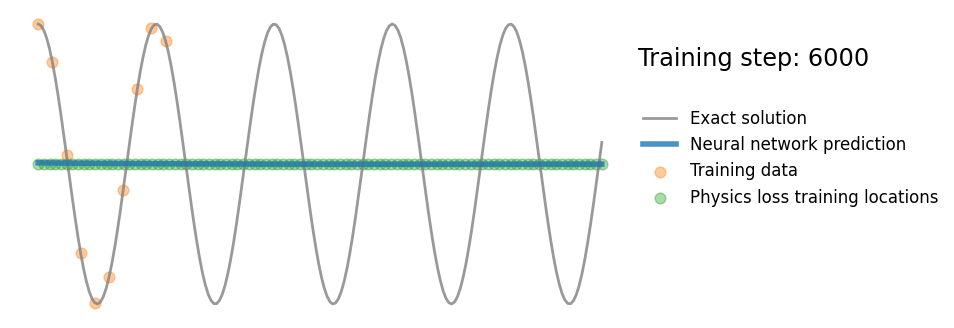

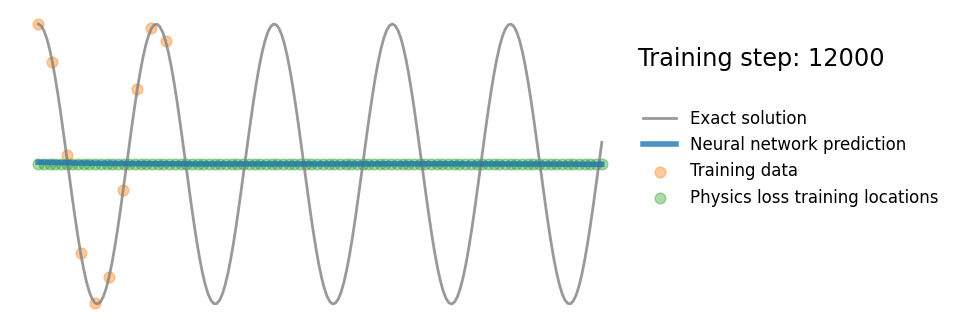

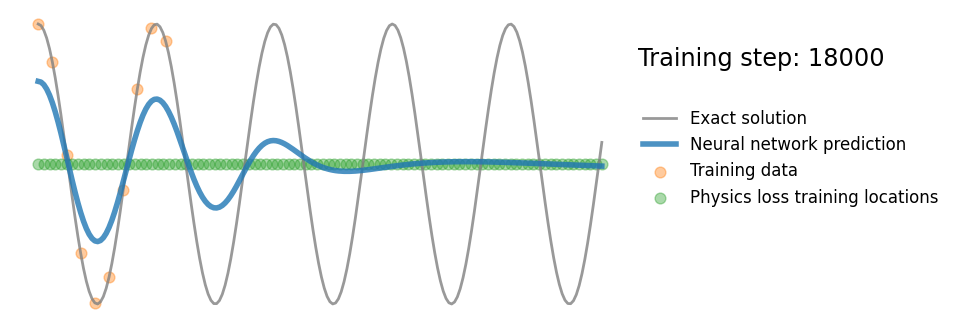

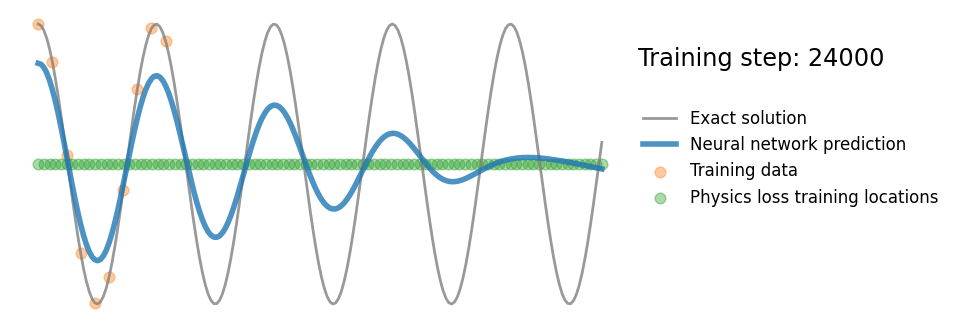

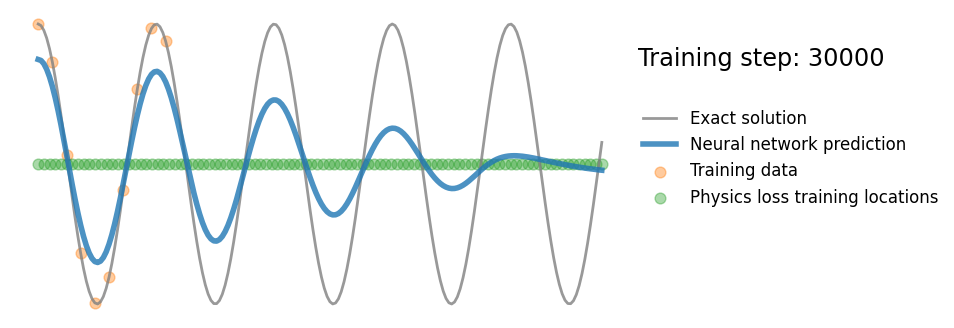

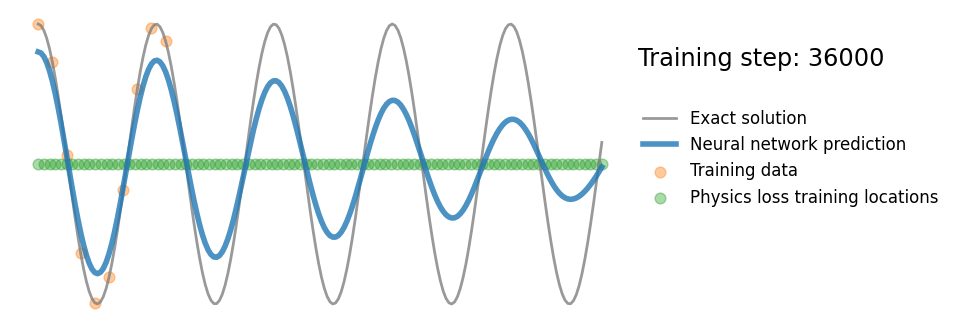

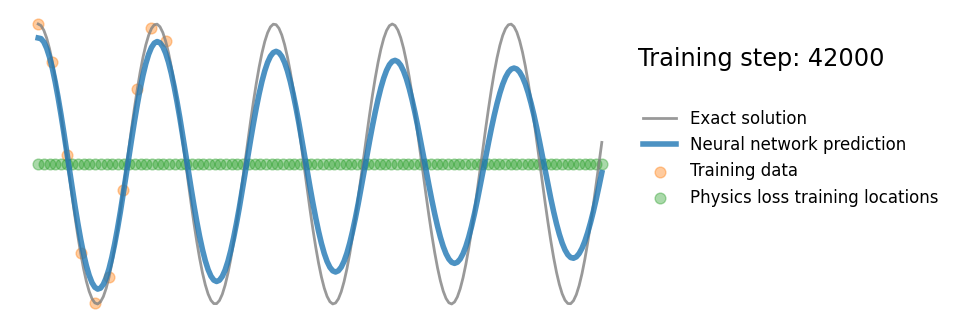

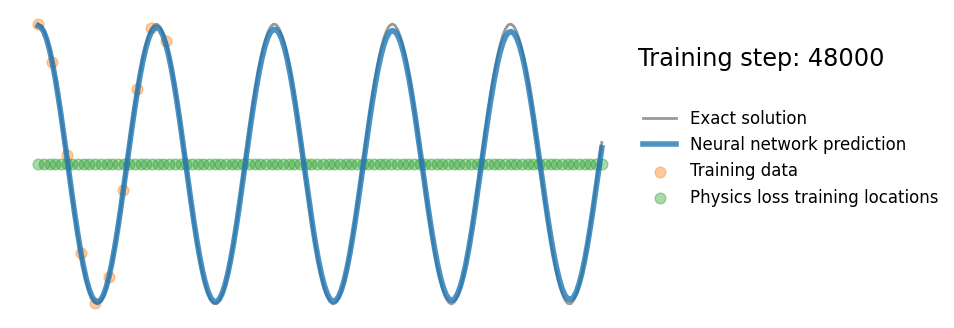

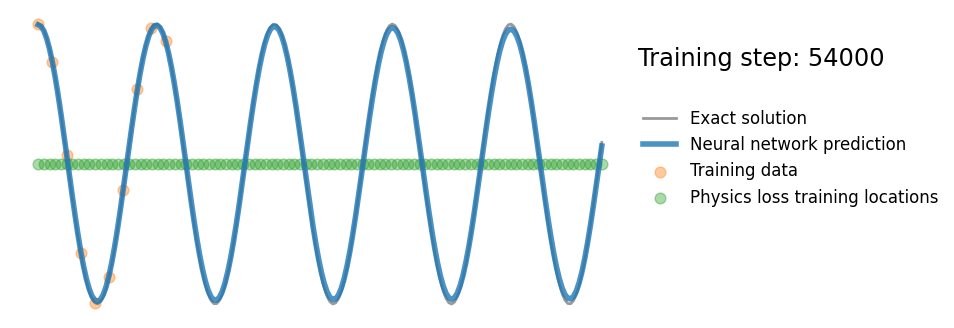

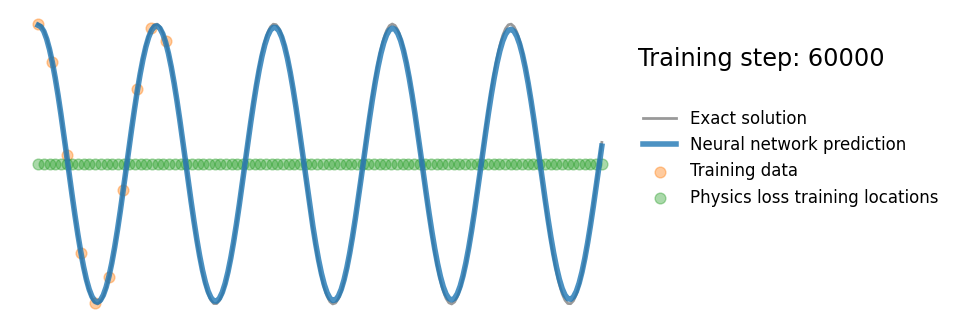

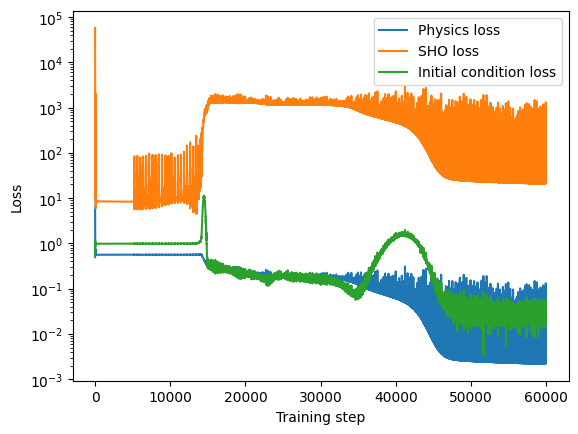

In [16]:
time_physics = torch.linspace(0, 1, 100).view(-1,1).requires_grad_(True) # Generate some time values that we will run the SHO neaural network on

initial_time = torch.tensor(0.).view(-1,1).requires_grad_(True) # providing initial time = 0 for initial conditions, x(t)=1, dx/dt=0
torch.manual_seed(1)
model = shoNN(1,1,32,3)
files = []
sho_loss_weight =  1e-4
initial_condition_loss_weight = 1e-4
#frequency = nn.Parameter(torch.zeros(1, requires_grad=True))
frequency = 30

#optimizer = torch.optim.Adam(list(model.parameters())+[frequency],lr=1e-2)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

losses_physics = []
losses_sho = []
losses_initial_condition = []

for i in range(60000):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss1 = torch.mean((sho_predicted-sho_samples)**2)# use mean squared error

    # compute the physics loss not on the boudnary or initial condition
    sho_predicted_physics, dtsho_predicted_physics, d2tsho_predicted_physics = compute_model_and_derivatives(model, time_physics)
    sho_loss = physics_loss(sho_predicted_physics, dtsho_predicted_physics, d2tsho_predicted_physics, frequency)

    # compute the initial condition loss
    initial_sho_x, initial_sho_dt, initial_sho_d2t = compute_model_and_derivatives(model, initial_time)
    initial_condition_loss = compute_initial_condition_loss(initial_sho_x, initial_sho_dt)

    loss = loss1 + sho_loss_weight*sho_loss + initial_condition_loss_weight*initial_condition_loss
    loss.backward()
    optimizer.step()
    losses_sho.append(sho_loss.item())
    losses_initial_condition.append(initial_condition_loss.item())
    losses_physics.append(loss.item())

    if (i+1) % 150 == 0:
        sho_predicted = model(time).detach()
        time_p = time_physics.detach()

        plot_result(time,sho_analytic_solution,time_samples,sho_samples,sho_predicted,time_p)
        file = "../plots/nn_physics_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0:
            plt.show()
        else:
            plt.close('all')

plt.plot(losses_physics, label="Physics loss")
plt.plot(losses_sho, label="SHO loss")
plt.plot(losses_initial_condition, label="Initial condition loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

save_gif_PIL('physics_nn.gif', files, fps=20, loop=0)

